# [EXPERIMENTAL] Handwritten Text Synthesis GAN

Differences from the original model:

- Instead of taking in a 128x2048 image, we take in a 32x256 image, reducing the size by 32 times to speed up the net and save memory

In [1]:
import csv
import datetime
import os
import random
import re

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch_fidelity
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn.utils.spectral_norm import spectral_norm
from torch.utils.data import DataLoader, Dataset, RandomSampler, Subset, random_split
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import Grayscale, Resize, ToTensor
from torchvision.transforms.functional import InterpolationMode

/home/kevin/miniconda3/envs/aps360/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading

### Helper Functions (Run once only to format data)

In [2]:
SCALE_HEIGHT = 32
SCALE_WIDTH = SCALE_HEIGHT*16

def preprocess_lines(data_root):
    """
    Creates a new `.txt` file `lines_improved.txt` that will be used
    for querying. This new `.txt` file contains all info necessary
    for the functionality of this project.
    """

    original_path = os.path.join(data_root, "lines.txt")
    improved_path = os.path.join(data_root, "lines_improved.txt")
    fi = open(improved_path, "w")

    # Some variables for tracking
    num_samples = 0
    valid_samples = 0
    
    # Loop through "lines.txt"
    with open(original_path, "r") as fo:
        headers = ["image_id", "image_path", "image_pt_path", "graylevel", "original_height", "original_width", "transcription", "transcription_len"]

        # First write the headers at the top of the file
        fi.writelines("\t".join(headers) + "\n")

        # Skip the intro stuff
        for line in fo.readlines():
            if line.startswith("#"):
                continue

            # Valid lines, not the intro_text
            line_items = line.strip().split(" ")  # `strip()` to remove newlines

            # The actual items (we extract the important ones)
            image_id = line_items[0]
            status = line_items[1]
            graylevel = int(line_items[2])
            transcription = " ".join(line_items[8:])  # Some data has whitespace, we join string till the end

            # Skip error images
            if status == "err":
                continue
        
            # Alphanumeric + common punctuation regex
            # Returns None if no match
            # 26 + 26 + 10 + 9 + 1 = 72
            # Spaces might be included as well
            # Punctuation include , ! ? ' " , : ; -
            if re.fullmatch("[a-zA-Z0-9.!?'\",:;| -]*", transcription) is None:
                continue

            # Now we have valid transcription
            num_samples += 1

            # We get the `.png` image path
            inp = image_id.split("-")  # `inp` stands for image name parts
            image_path_head = os.path.join(data_root, "lines", inp[0], f"{inp[0]}-{inp[1]}")
            image_path_tail = f"{image_id}.png"
            image_path = os.path.join(image_path_head, image_path_tail)
            
            # Read image, gets its dimensions, perform processing operations, and other stuff
            tmp_image = cv.imread(os.path.join(image_path_head, image_path_tail), cv.IMREAD_GRAYSCALE)  # Removes the channel dimension
            height, width = tmp_image.shape

            # Scaling calculations
            # If width * scale >= desired length (>= to be safe)
            # Condition here to speed up overall processing time
            if width * (SCALE_HEIGHT/height) >= SCALE_WIDTH:
                continue

            resized_tensor = process_image(tmp_image, graylevel)
            image_pt_path = os.path.join(image_path_head, f"{image_id}.pt")
            torch.save(resized_tensor, image_pt_path)

            # A fully valid image
            # Separate by underscores because `transcription` has spaces so we can't split by spaces
            fi.writelines(f"{image_id}\t{image_path}\t{image_pt_path}\t{graylevel}\t{height}\t{width}\t{transcription}\t{len(transcription)}\n")
            valid_samples += 1
        
        fi.close()
    
    print("# samples:", num_samples)
    print("Valid samples:", valid_samples)


def process_image(cv_image, graylevel):
    """
    Takes in a grayscale image that OpenCV read of shape (H, W) of type uint8
    Returns a PyTorch tensor of shape (1, 32, W'), where W' is the scaled width
    This tensor is padded and effectively thresholded
    """

    # Scaling factor
    height, width = cv_image.shape
    scale = SCALE_HEIGHT/height
    scaled_width = int(width*scale)

    # Trick here is to apply threshold before resize and padding
    # This allows OpenCV resizing to create a cleaner output image
    # 2nd return value is the thresholded image
    output = cv.threshold(cv_image, graylevel, 255, cv.THRESH_BINARY)[1]

    # INTER_AREA recommended for sizing down
    output = cv.resize(output, (scaled_width, SCALE_HEIGHT), interpolation=cv.INTER_AREA)

    # Turn it back to a tensor and map to [0, 1]
    output = torch.from_numpy(output).unsqueeze(0).type(torch.float32)
    output = (output-output.min()) / (output.max()-output.min())
    
    # Add padding
    _, _, resized_height = output.shape
    padding_to_add = SCALE_WIDTH - resized_height
    output = F.pad(output, (0, padding_to_add), value=1.0)

    return output

# Uncomment this if your data isn't processed yet
# preprocess_lines("./data/")

### Important Dict (Run everytime before training)

In [3]:
# Sorted by ascii code
valid = [
    ' ', '!', '"', "'", ',', '-', '.',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
    ':', ';', '?', 
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
]
# Enumerate from 1 to save space for padding
char_to_int = {v: i for i, v in enumerate(valid, 1)}
int_to_char = {i: v for i, v in enumerate(valid, 1)}

### Code for Dataset

In [4]:
class LineDataset(Dataset):
    def __init__(self, lines_improved_dir, ty=None):
        """
        params:
            lines_improved_dir: path to the `lines_improved.txt` file
            ty: type of the dataset "txt", "img" for text dataset or image dataset.
        """
        
        # Dataframe containing the stuff in `lines_improved.txt`
        self.lines_df = pd.read_csv(lines_improved_dir, sep="\t", quoting=csv.QUOTE_NONE)

        # Class properties
        self.ty = ty  # Type of dataset (lines, images, or both)
        self.max_transcription_len = max(self.lines_df["transcription_len"])

        # Temp variables...
        length = self.lines_df.shape[0]
        line_datas = self.lines_df.iloc
        ret_texts = [line_datas[i]["transcription"].replace('|', ' ') for i in range(length)]
        ret_ctois = [torch.tensor([char_to_int[char] for char in ret_texts[i]]) for i in range(length)]

        # ...for the important data
        if self.ty in ("txt", None):  # Added this condition to speed thigns up if only text
            self.ret_ctoi_paddeds = [F.pad(ret_ctois[i], pad=(0, self.max_transcription_len-len(ret_ctois[i]))) for i in range(length)]
        if self.ty in ("img", None):
            self.ret_images = [torch.load(line_datas[i]["image_pt_path"]) for i in range(length)]

    def __len__(self):
        return len(self.lines_df)
    
    def __getitem__(self, index):
        # Different type of individual loaders
        if self.ty == "txt":
            return self.ret_ctoi_paddeds[index]
        elif self.ty == "img":
            return self.ret_images[index]
        else:
            return self.ret_images[index], self.ret_ctoi_paddeds[index]

### Initializing the Dataloaders

In [5]:
# Loading in the datasets
line_transcription_dataset = LineDataset("./data/lines_improved.txt", ty="txt")
line_image_dataset = LineDataset("./data/lines_improved.txt", ty="img")
line_dataset = LineDataset("./data/lines_improved.txt")

# lol if we use CUDA then say goodbye to reproducible results (help me figure how to do this)
# We might need to set more than just a torch.manual_seed()
torch.manual_seed(12345678)  # DO NOT REMOVE THIS LINE
line_transcription_dataset_train, line_transcription_dataset_val = random_split(line_transcription_dataset, [0.8, 0.2])
line_image_dataset_train, line_image_dataset_val = random_split(line_image_dataset, [0.8, 0.2])
line_dataset_train, line_dataset_val = random_split(line_dataset, [0.8, 0.2])

print("lines")
print(len(line_transcription_dataset_train), len(line_transcription_dataset_val))
print("images")
print(len(line_image_dataset_train), len(line_image_dataset_val))
print("both")
print(len(line_dataset_train), len(line_dataset_val))

lines
5708 1427
images
5708 1427
both
5708 1427


In [6]:
# To train on a small dataset
line_transcription_dataset_train = Subset(line_transcription_dataset_train, range(500))
line_transcription_dataset_val = Subset(line_transcription_dataset_val, range(500))

line_image_dataset_train = Subset(line_image_dataset_train, range(500))
line_image_dataset_val = Subset(line_image_dataset_val, range(500))

print("lines")
print(len(line_transcription_dataset_train), len(line_transcription_dataset_val))
print("images")
print(len(line_image_dataset_train), len(line_image_dataset_val))
print("both")
print(len(line_dataset_train), len(line_dataset_val))

lines
500 500
images
500 500
both
5708 1427


### Visualizing some Examples (Simply press enter repeatedly)

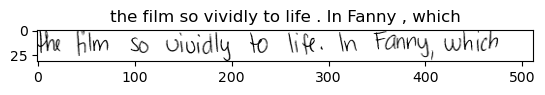

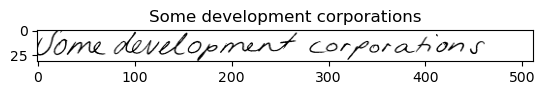

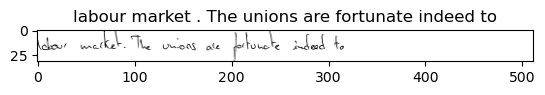

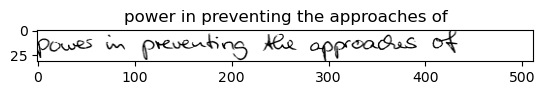

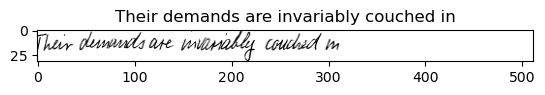

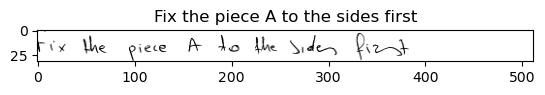

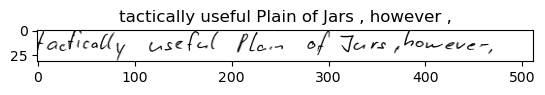

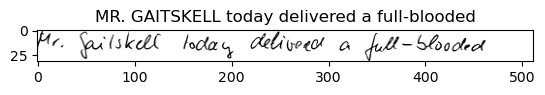

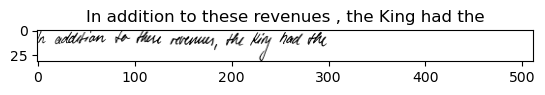

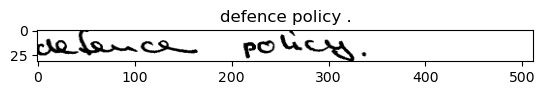

In [7]:
for i in range(10):
    image, label = line_dataset_train[random.randint(0, 5708-1)]  # Change if size of loader changes
    plt.figure()
    plt.title("".join([int_to_char[int(val)] for val in label[label.nonzero()]]))
    plt.imshow(image.permute(1, 2, 0), cmap='gray')
# label, "".join([int_to_char[int(val)] for val in label[label.nonzero()]])

### Tutorial How to Use FID

In [7]:
len(line_image_dataset_train), len(line_image_dataset_val)
# fid.reset()

(500, 500)

In [15]:
test_loader1 = DataLoader(line_image_dataset_train, batch_size=500, shuffle=True)
test_loader2 = DataLoader(line_image_dataset_val, batch_size=500, shuffle=True)

example_fake = next(iter(test_loader2))
# Need to turn the batch to uint8 with 3 channels for FID
example_fake = example_fake.repeat(1, 3, 1, 1)

fid = FrechetInceptionDistance(feature=2048, normalize=True, reset_real_features=False)

for ba in test_loader1:
    print(ba.shape)
    fid.update(ba.repeat(1, 3, 1, 1), real=True)

print("a")
# fid.update(example_fake, real=False)
fid.update(example_fake, real=False)
print("b")
# fid.update(torch.randn((200, 3, 32, 512)), real=False)
# print(np.mean(fid))

torch.Size([500, 1, 32, 512])
a
b


In [16]:
fid.compute()

tensor(12.9932)

In [17]:
test_loader2 = DataLoader(line_image_dataset_val, batch_size=5, shuffle=True)
fid.reset()
# batch = next(iter(test_loader1))
# print(len(batch))
# fid.update(batch.repeat(1, 3, 1, 1), real=True)

for ba in test_loader2:
    print(ba.shape)
    fid.update(ba.repeat(1, 3, 1, 1), real=False)
print("a")
print(fid.compute())

torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 32

### Observation

First we initialize FID
- Init weights on 500 real images
- Init weights on 500 fake images
- fid.compute() return some value V

We reinint FIT
- Init weights on 500 real images
- Loop through fake images batch, doesn't matter the batch size (say 29)
  - update FID with 29 fake images
  - update FID with 29 fake images
  ...
  - update FID with 29 fake images
  - update FID with the renaming images
- fid.compute() return the same value Y

If we initialize the FID object with reset_real_features=False,
then we only need to run the fid() function once before the training loop